In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-78f161d3-9fa5-dcc9-29f9-e70ca1a57789)


## Getting the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [ ]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 364 ms, sys: 87 ms, total: 451 ms
Wall time: 456 ms


(180040, 30212, 30135)

In [ ]:
train_samples[1:14]

[{'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
  'line_number': 4,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscr

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

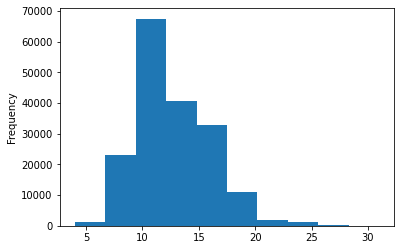

In [ ]:
train_df.total_lines.plot.hist()

## Get lists of sentences

In [ ]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encoder labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

### Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

#### Downloading helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-28 15:40:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-28 15:40:10 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sent_lens)
avg_sentence_len

26.338269273494777

In [ ]:
import matplotlib.pyplot as plt

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <a list of 7 Patch objects>)

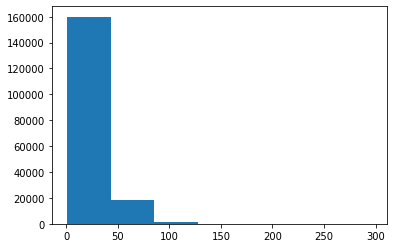

In [ ]:
plt.hist(sent_lens, bins=7)

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

#### Create text vectorizer

In [ ]:
max_tokens = 68000 # vocabulary size specified in the PubMed 200k RCT paper

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized Text: \n{text_vectorizer([target_sentence])}')

Text:
future studies should aim to confirm these findings .

Length of text: 9

Vectorized Text: 
[[ 652  202  406  267    6 1482  111  310    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocabulary: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocabulary: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}')

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero=True, # Use masking to handle variable sequence length (save space)
                               name='token_embedding')

In [ ]:
print(f'Sentence before vectorization: \n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding: \n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
future studies should aim to confirm these findings .

Sentence after vectorization: 
[[ 652  202  406  267    6 1482  111  310    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding: 
[[[-0.04505185  0.04869367 -0.04520411 ... -0.01458311 -0.03478713
   -0.02354833]
  [ 0.02657006 -0.00885605  0.011589   ...  0.01363895 -0.00609255
    0.01372619]
  [-0.002026   -0.04020616 -0.01333902 ...  0.02270189 -0.02646427
   -0.03291412]
  ...
  [-0.02380159 -0.01753969 -0.0085127  ... -0.04107292 -0.02194637
   -0.02223184]
  [-0.02380159 -0.01753969 -0.0085127  ... -0.04107292 -0.02194637
   -0.02223184]
  [-0.02380159 -0.01753969 -0.0085127  ... -0.04107292 -0.02194637
   -0.02223184]]]

Embedded sentence shape: (1, 55, 128)


#### Create datasets (as fast as possible)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 9ms/step - loss: 0.9293 - accuracy: 0.6292 - val_loss: 0.6888 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6519 - accuracy: 0.7595 - val_loss: 0.6265 - val_accuracy: 0.7749
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6130 - accuracy: 0.7743 - val_loss: 0.5965 - val_accuracy: 0.7856


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5963 - accuracy: 0.7870


[0.5962799787521362, 0.787038266658783]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.7234270e-01, 1.1692805e-01, 4.8637696e-02, 3.4438011e-01,
        1.7711440e-02],
       [4.5160416e-01, 2.7318674e-01, 1.6905280e-02, 2.4626185e-01,
        1.2042013e-02],
       [1.8295930e-01, 4.3387203e-03, 1.8441338e-03, 8.1081945e-01,
        3.8500602e-05],
       ...,
       [8.9706691e-06, 6.5772433e-04, 6.4903666e-04, 5.8676160e-06,
        9.9867839e-01],
       [4.5236059e-02, 4.6123469e-01, 9.1383904e-02, 5.0024562e-02,
        3.5212076e-01],
       [1.6824903e-01, 7.1810830e-01, 3.9122026e-02, 4.6911269e-02,
        2.7609354e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70382629418773,
 'precision': 0.7840914327436013,
 'recall': 0.7870382629418774,
 'f1': 0.7845059580587429}

### Model 2: Feature extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f'Random traning sentence:\n{random_training_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f'Sentence after embedding:\n {use_embedded_sentence[0][:30]} (truncated output) \n')
print(f'Length of sentence embedding:\n {len(use_embedded_sentence[0])}')

Random traning sentence:
map before intubation decreased significantly compared with the map at baseline to the same extent in both groups ; ephedrine iv was given in @ ( sevo ) versus @ ( mr ) patients ; p = @ .
Sentence after embedding:
 [-0.03528027 -0.04258229  0.01441544 -0.05668248  0.025243    0.02478013
  0.07627775  0.01172031  0.04909216  0.05391357  0.08790638  0.04050973
  0.05267325  0.07946775  0.05424155  0.05283442 -0.08736521 -0.03507474
 -0.05731251  0.01839782 -0.01140054  0.00378047 -0.06849555 -0.03193685
  0.04160545  0.00104237  0.01743661  0.0266814  -0.02711715 -0.00765911] (truncated output) 

Length of sentence embedding:
 512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            epochs=3,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9170 - accuracy: 0.6510 - val_loss: 0.7944 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7671 - accuracy: 0.7028 - val_loss: 0.7526 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7491 - accuracy: 0.7132 - val_loss: 0.7337 - val_accuracy: 0.7151


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7371 - accuracy: 0.7165


[0.7370852828025818, 0.7165364623069763]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 10ms/step


array([[4.1840476e-01, 3.5884047e-01, 2.4216932e-03, 2.1196690e-01,
        8.3662001e-03],
       [3.7902084e-01, 4.7518328e-01, 4.2191586e-03, 1.3911802e-01,
        2.4587966e-03],
       [2.2138548e-01, 1.6061319e-01, 1.7369431e-02, 5.6496871e-01,
        3.5663161e-02],
       ...,
       [2.0515977e-03, 7.2925873e-03, 5.9246492e-02, 8.7434129e-04,
        9.3053496e-01],
       [4.0654726e-03, 4.1404583e-02, 1.8287815e-01, 1.5623857e-03,
        7.7008933e-01],
       [1.9243123e-01, 3.1934950e-01, 4.3037078e-01, 7.3937038e-03,
        5.0454836e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.65364755726202,
 'precision': 0.7163011636859811,
 'recall': 0.7165364755726201,
 'f1': 0.7133483044910186}

### Model 3: Conv1D with character embeddings

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

split_chars(random_training_sentence)

'm a p   b e f o r e   i n t u b a t i o n   d e c r e a s e d   s i g n i f i c a n t l y   c o m p a r e d   w i t h   t h e   m a p   a t   b a s e l i n e   t o   t h e   s a m e   e x t e n t   i n   b o t h   g r o u p s   ;   e p h e d r i n e   i v   w a s   g i v e n   i n   @   (   s e v o   )   v e r s u s   @   (   m r   )   p a t i e n t s   ;   p   =   @   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

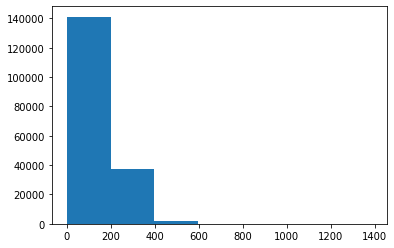

In [ ]:
plt.hist(char_lens, bins=7)

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'\nLength of chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n{vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
t h e s e   r e s u l t s   s u g g e s t   t h a t   a   r a n d o m i z e d   t r i a l   w i t h   a   l a r g e r   s a m p l e   s i z e   a n d   a   h i g h e r   d o s a g e   o f   p r a v a s t a t i n   w o u l d   b e   h e l p f u l   i n   f u r t h e r   e v a l u a t i n g   t h e   a n t i - i n f l a m m a t o r y   p r o p e r t i e s   o f   p r a v a s t a t i n   ,   i t s   a s s o c i a t i o n   w i t h   i m p r o v e m e n t s   i n   c o g n i t i v e   s y m p t o m s   ,   a n d   i t s   p o t e n t i a l   t o   r e d u c e   p o s i t i v e   a n d   n e g a t i v e   s y m p t o m s   a s s o c i a t e d   w i t h   s c h i z o p h r e n i a   o r   s c h i z o a f f e c t i v e   d i s o r d e r s   .

Length of chars: 320
Vectorized chars:
[[ 3 13  2  9  2  8  2  9 16 12  3  9  9 16 18 18  2  9  3  3 13  5  3  5
   8  5  6 10  7 15  4 25  2 10  3  8  4  5 12 20  4  3 13  5 12  5  8 18
   2  8  9  5 15 14 12  2  9  4 25  2  5  6 10  5 

In [ ]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name='char_embed')

print(f'Charified text (before vectorization and embedding): \n{random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding): \n {char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text (before vectorization and embedding): 
t h e s e   r e s u l t s   s u g g e s t   t h a t   a   r a n d o m i z e d   t r i a l   w i t h   a   l a r g e r   s a m p l e   s i z e   a n d   a   h i g h e r   d o s a g e   o f   p r a v a s t a t i n   w o u l d   b e   h e l p f u l   i n   f u r t h e r   e v a l u a t i n g   t h e   a n t i - i n f l a m m a t o r y   p r o p e r t i e s   o f   p r a v a s t a t i n   ,   i t s   a s s o c i a t i o n   w i t h   i m p r o v e m e n t s   i n   c o g n i t i v e   s y m p t o m s   ,   a n d   i t s   p o t e n t i a l   t o   r e d u c e   p o s i t i v e   a n d   n e g a t i v e   s y m p t o m s   a s s o c i a t e d   w i t h   s c h i z o p h r e n i a   o r   s c h i z o a f f e c t i v e   d i s o r d e r s   .

Embedded chars (after vectorization and embedding): 
 [[[-0.04451673 -0.02320532 -0.04611097 ...  0.02309916  0.00151398
   -0.04715282]
  [ 0.03989102  0.03640368  0.03684259 ...  0.03426322  0.0051

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
chars_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(chars_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1D_char_embedding')
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              validation_data=val_char_dataset,
                              steps_per_epoch=int(len(train_char_dataset) * 0.1),
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2750 - accuracy: 0.4908 - val_loss: 1.0434 - val_accuracy: 0.5947
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9982 - accuracy: 0.6050 - val_loss: 0.9322 - val_accuracy: 0.6413
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9055 - accuracy: 0.6436 - val_loss: 0.8616 - val_accuracy: 0.6699


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.16755322, 0.47396228, 0.08957415, 0.22863162, 0.04027874],
       [0.20360024, 0.39351243, 0.021369  , 0.31814632, 0.06337206],
       [0.0873927 , 0.36166593, 0.21886973, 0.24574043, 0.08633126],
       ...,
       [0.01231916, 0.03470423, 0.11892112, 0.0276151 , 0.80644035],
       [0.18426163, 0.16684818, 0.25731242, 0.11184506, 0.27973267],
       [0.4282335 , 0.34282184, 0.13332199, 0.08334202, 0.01228062]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 65.84469747120349,
 'precision': 0.6569708487168682,
 'recall': 0.658446974712035,
 'f1': 0.6481998741645484}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embeddings)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs = output_layer,
                         name = 'model_4_token_and_char_embeddings')

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

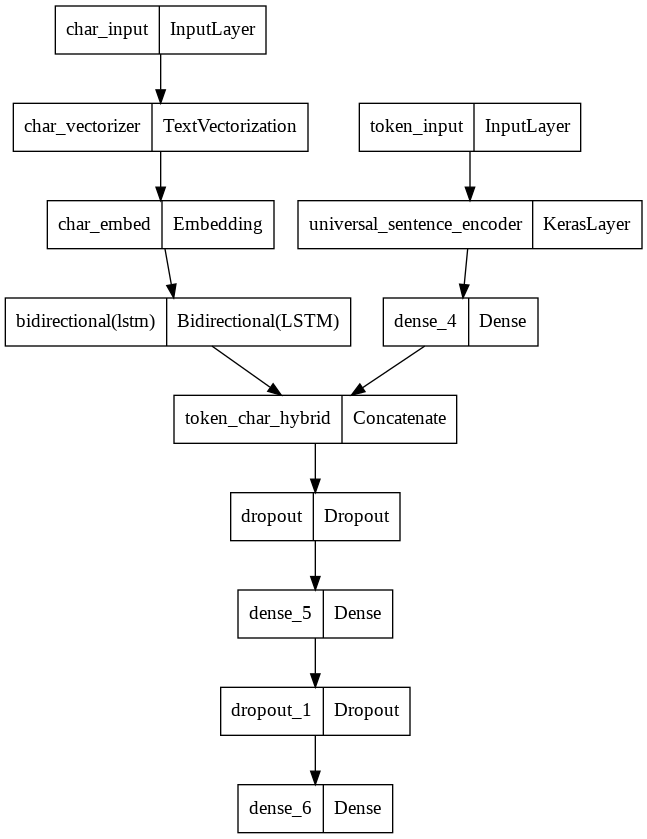

In [ ]:
tf.keras.utils.plot_model(model_4)

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 36ms/step - loss: 0.9699 - accuracy: 0.6170 - val_loss: 0.7747 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7955 - accuracy: 0.6958 - val_loss: 0.7137 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7644 - accuracy: 0.7074 - val_loss: 0.6946 - val_accuracy: 0.7380


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6965 - accuracy: 0.7342


[0.6964665055274963, 0.7342115640640259]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 20ms/step


array([[4.1744030e-01, 3.8307795e-01, 4.0964410e-03, 1.8755347e-01,
        7.8318780e-03],
       [3.6899376e-01, 4.0537217e-01, 5.0141159e-03, 2.1774971e-01,
        2.8702933e-03],
       [3.0305234e-01, 1.3080601e-01, 4.8309188e-02, 4.7715607e-01,
        4.0676322e-02],
       ...,
       [4.7857463e-04, 7.7937557e-03, 4.7022987e-02, 1.0203755e-04,
        9.4460267e-01],
       [5.9130546e-03, 5.5338468e-02, 2.0392992e-01, 2.2675868e-03,
        7.3255098e-01],
       [3.7993261e-01, 3.9236307e-01, 1.3333178e-01, 5.0017625e-02,
        4.4354934e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 73.42115715609691,
 'precision': 0.7344743348505155,
 'recall': 0.7342115715609692,
 'f1': 0.7323681095282357}

### Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [ ]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:20]

(TensorShape([180040, 20]), <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# total lines input
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name='token_char_positional_embeddings')([line_number_model.output,
                                                                total_lines_model.output,
                                                                 z])

output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

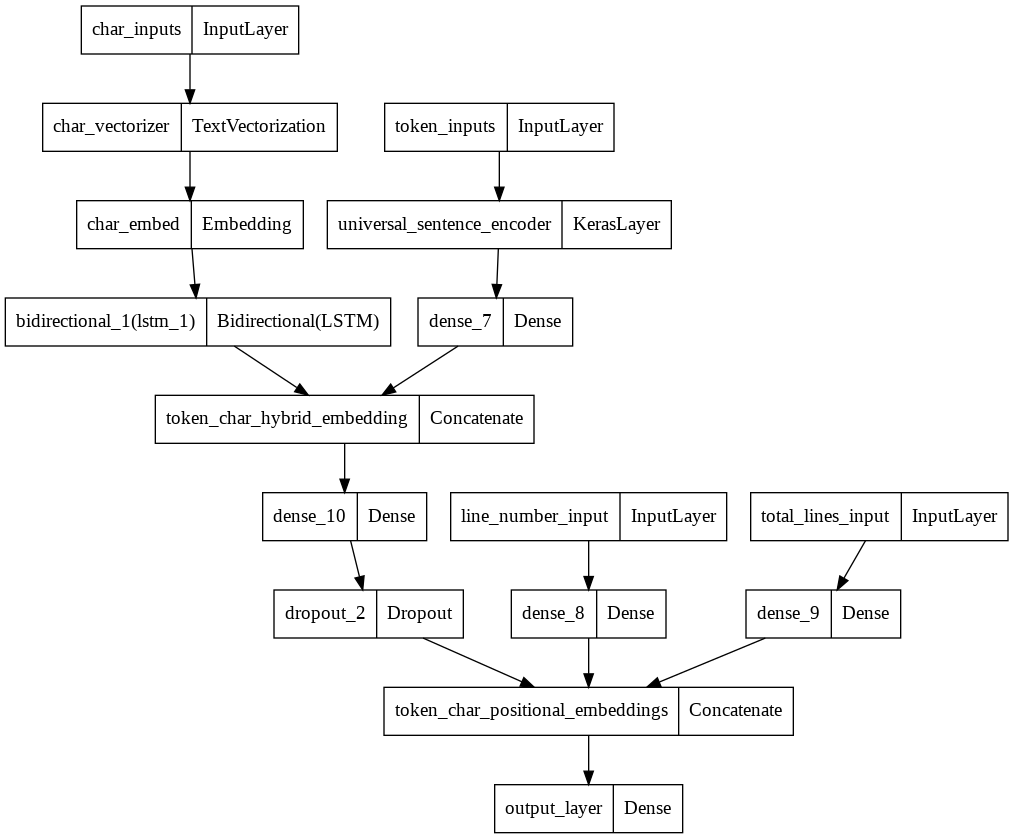

In [ ]:
tf.keras.utils.plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 45ms/step - loss: 1.0971 - accuracy: 0.7208 - val_loss: 0.9837 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.9677 - accuracy: 0.8153 - val_loss: 0.9512 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9509 - accuracy: 0.8258 - val_loss: 0.9399 - val_accuracy: 0.8295


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[0.47819382, 0.10684466, 0.01220685, 0.38015303, 0.02260162],
       [0.48811615, 0.10506875, 0.03576804, 0.36200085, 0.00904613],
       [0.26677918, 0.10664079, 0.10179061, 0.4548882 , 0.06990121],
       ...,
       [0.03386495, 0.09655634, 0.03511225, 0.03134321, 0.80312324],
       [0.02995956, 0.26704532, 0.07380244, 0.02463412, 0.6045586 ],
       [0.21873981, 0.5339785 , 0.12547518, 0.04435145, 0.0774551 ]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.05309148682642,
 'precision': 0.8293505665091054,
 'recall': 0.8305309148682642,
 'f1': 0.8296225517131179}

## Comparing model results

In [ ]:
all_model_results = pd.DataFrame({
    'baseline': baseline_results,
    'custom_token_embed_conv1d': model_1_results,
    'pretrained_token_embed': model_2_results,
    'custom_char_embed_conv1d': model_3_results,
    'hybrid_char_token_embed': model_4_results,
    'tribird_pos_char_token_embed': model_5_results
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.703826,0.784091,0.787038,0.784506
pretrained_token_embed,71.653648,0.716301,0.716536,0.713348
custom_char_embed_conv1d,65.844697,0.656971,0.658447,0.648200
hybrid_char_token_embed,73.421157,0.734474,0.734212,0.732368
tribird_pos_char_token_embed,83.053091,0.829351,0.830531,0.829623


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

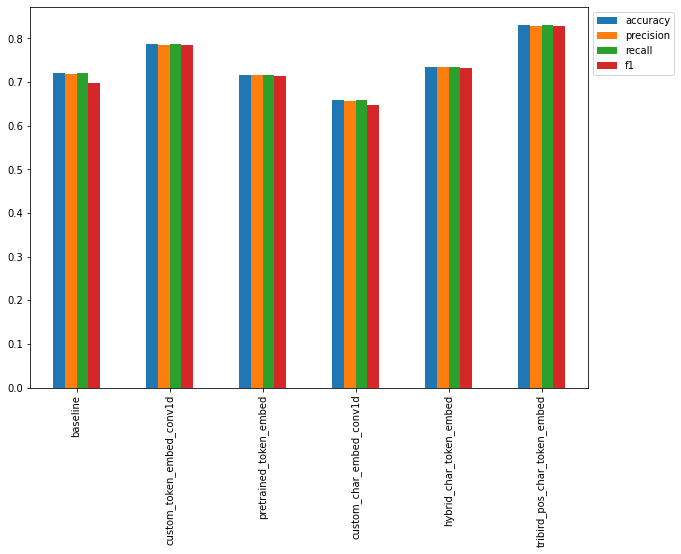

In [ ]:
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

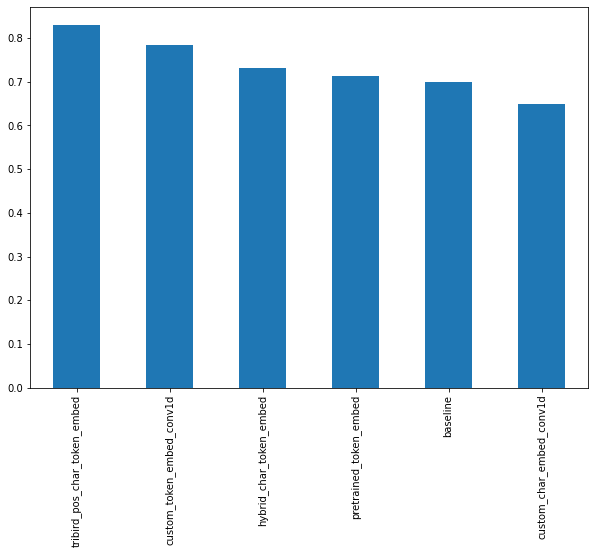

In [ ]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

## Save and load the best performing model

In [ ]:
# Saving the best performing model to SavedModel format (default)
model_5.save('skimlit_tribird_model')

In [ ]:
loaded_model = tf.keras.models.load_model('skimlit_tribird_model')

In [ ]:
loaded_model_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_preds[:10]

945/945 [==============================] - 21s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(val_labels_encoded, loaded_model_preds)

In [ ]:
loaded_model_results

{'accuracy': 83.05309148682642,
 'precision': 0.8293505665091054,
 'recall': 0.8305309148682642,
 'f1': 0.8296225517131179}

In [ ]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()))

array([ True,  True,  True,  True])

In [ ]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [ ]:
for layer in loaded_model.layers:
  print(layer.trainable)

True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True


## Evaluate model on test dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset, verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 20s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
loaded_model_test_results = calculate_results(test_labels_encoded, test_preds)
loaded_model_test_results

{'accuracy': 82.5286212045794,
 'precision': 0.8238756397937854,
 'recall': 0.8252862120457939,
 'f1': 0.8243034884593348}

## Finding most wrong predictions

In [ ]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 11.8 s, sys: 787 ms, total: 12.6 s
Wall time: 11.1 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'R

In [ ]:
test_df['prediction'] = test_pred_classes
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df['correct'] = test_df['prediction'] == test_df['target']
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9,OBJECTIVE,0.484529,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,9,BACKGROUND,0.338844,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9,METHODS,0.803655,False
3,RESULTS,survival analyses were used to assess the asso...,3,9,METHODS,0.661762,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9,RESULTS,0.700578,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,9,RESULTS,0.875410,True
6,RESULTS,multivariable analyses revealed that patients ...,6,9,RESULTS,0.554393,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,9,CONCLUSIONS,0.462905,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,9,RESULTS,0.539765,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,0.563025,True


In [ ]:
top_100_wrong = test_df[test_df['correct'] == False].sort_values('pred_prob', ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,13,OBJECTIVE,0.948459,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,7,METHODS,0.940603,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,12,OBJECTIVE,0.932566,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,14,METHODS,0.930403,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,10,RESULTS,0.927190,False
...,...,...,...,...,...,...,...
28391,RESULTS,cox proportional hazards analyses were used to...,3,11,METHODS,0.841696,False
18003,RESULTS,this formulation produced highly significant a...,12,21,CONCLUSIONS,0.841482,False
25345,RESULTS,participants were randomized to an hpd or an s...,3,13,METHODS,0.840101,False
25047,RESULTS,"three years after loading , patients with mand...",14,20,CONCLUSIONS,0.839807,False


In [ ]:
for row in top_100_wrong.itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f'Target: {target}, pred: {prediction}, prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n')
  print(f'Text: \n{text}\n')
  print('-----\n')

Target: BACKGROUND, pred: OBJECTIVE, prob: 0.9484594464302063, Line number: 0, Total lines: 13

Text: 
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, pred: METHODS, prob: 0.9406030178070068, Line number: 4, Total lines: 7

Text: 
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, pred: OBJECTIVE, prob: 0.9325658679008484, Line number: 0, Total lines: 12

Text: 
to assess the temporal patterns of late gastrointestinal ( gi ) and genitourinary ( gu ) radiotherapy toxicity and resolution rates in a randomised controlled trial ( all-ireland cooperative oncology research group @-@ ) assessing duration of neo-adjuvant ( na ) hormone therapy for localised prostate cancer .

-----

Target: RESULTS, pred: METHODS, prob: 0.9304026365280151, Line number: 4, Total lines: 14

Text: 
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target